In [18]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '16g') \
    .config("spark.driver.memory",'45g') \
    .config("spark.driver.maxResultSize", '30g') \
    .getOrCreate()

sc = spark.sparkContext

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [20]:
#Define preprocessing pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

# load pre-cleaned dataset

In [21]:
clean_df = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")
clean_df.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|       0.0|        1.0|        5.0|         0.0|
|file:/project/ds5...|[0.0, 0.0, 0.

In [22]:
#Image_Features=clean_df.select(clean_df.features_2.alias("features"))
Image_Features=clean_df.select(clean_df.features_2)
Image_Features.show(5)

+--------------------+
|          features_2|
+--------------------+
|[0.69691276550292...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.14396619796752...|
|[0.0,0.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [23]:
Image_Features.cache()

DataFrame[features_2: vector]

In [24]:
# get size of features vector
len(Image_Features.first()[0])

100352

In [25]:
#Image_Features.count()

In [26]:
"""
from pyspark.ml.feature import VectorSlicer
vs = VectorSlicer(inputCol = "features", outputCol="features_2", indices=[*range(0,100351)])
Image_Features = vs.transform(Image_Features)
"""

'\nfrom pyspark.ml.feature import VectorSlicer\nvs = VectorSlicer(inputCol = "features", outputCol="features_2", indices=[*range(0,100351)])\nImage_Features = vs.transform(Image_Features)\n'

In [27]:
Image_Features.show()
Image_Features.cache()

+--------------------+
|          features_2|
+--------------------+
|[0.69691276550292...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.14396619796752...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,1.2510892152...|
|[0.46226453781127...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.8936254978...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[2.3670494556427,...|
+--------------------+
only showing top 20 rows



DataFrame[features_2: vector]

In [28]:
# PCA to reduced vector size

In [29]:
%%time
from pyspark.ml.feature import PCA
pca = PCA(k=50,inputCol="features_2", outputCol="pcaFeatures")

CPU times: user 1.89 ms, sys: 400 µs, total: 2.29 ms
Wall time: 3.81 ms


In [30]:
%%time 
model = pca.fit(Image_Features)

CPU times: user 25.4 ms, sys: 11.3 ms, total: 36.8 ms
Wall time: 2min 58s


In [31]:
%%time 
np.round(100.00*model.explainedVariance.toArray(),2)

CPU times: user 794 µs, sys: 1.07 ms, total: 1.86 ms
Wall time: 4.07 ms


array([15.  , 10.98,  8.3 ,  6.87,  4.65,  3.79,  3.09,  2.95,  2.57,
        2.45,  2.36,  2.27,  2.22,  1.97,  1.76,  1.71,  1.53,  1.41,
        1.29,  1.21,  1.14,  1.09,  1.04,  1.01,  0.95,  0.94,  0.9 ,
        0.87,  0.83,  0.8 ,  0.78,  0.76,  0.73,  0.69,  0.67,  0.66,
        0.65,  0.63,  0.62,  0.6 ,  0.59,  0.56,  0.55,  0.54,  0.54,
        0.53,  0.5 ,  0.5 ,  0.49,  0.47])

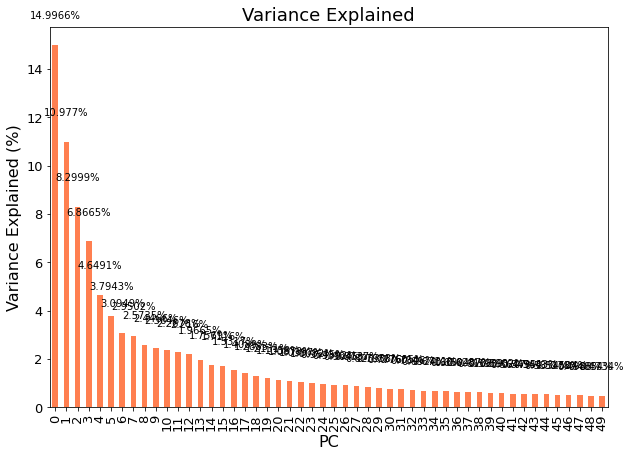

In [33]:
var = pd.DataFrame ({'variance':np.round(model.explainedVariance * 100,4), 'PC':['p' + str(i) for i in range(1,51)]})

ax = var.plot(kind='bar', figsize=(10,7), color="coral", fontsize=13, legend = False)
ax.set_alpha(0.8)
ax.set_title("Variance Explained", fontsize=18)
ax.set_xlabel("PC", fontsize=16)
ax.set_ylabel("Variance Explained (%)", fontsize=16)

rects = ax.patches
labels = list(var['variance'])
labels = [str(variance) +'%' for variance in labels]
                          

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha ='center', va='bottom')

In [ ]:
%%time 
model.save("pcaModel_50")